https://www.guru99.com/rnn-tutorial.html

In [4]:
import numpy as np


import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

n_inputs = 4
n_neurons = 6
n_timesteps = 2
#The data is a sequence of a number from 0 to 9 and divided into three batches of data.
## Data 
X_batch = np.array([
        [[0, 1, 2, 5], [9, 8, 7, 4]], # Batch 1
        [[3, 4, 5, 2], [0, 0, 0, 0]], # Batch 2
        [[6, 7, 8, 5], [6, 5, 4, 2]], # Batch 3
    ])

In [5]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

RuntimeError: tf.placeholder() is not compatible with eager execution.

# Understanding Model Architecture
Importing our necessities first.

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [7]:
# lstm autoencoder to recreate a timeseries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

# Creating an example data

We will create a toy example of a multivariate time-series data.

In [8]:
# define input timeseries
timeseries = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()

timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]
timeseries


array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

In [14]:
timeseries.shape[0]

9

As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. In this example, the n_features is 2. We will make timesteps = 3. With this, the resultant n_samples is 5 (as the input data has 9 rows).

In [9]:
timesteps = 3
X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)

n_features = 2
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

X

array([[[0.3  , 0.027],
        [0.4  , 0.064],
        [0.5  , 0.125]],

       [[0.4  , 0.064],
        [0.5  , 0.125],
        [0.6  , 0.216]],

       [[0.5  , 0.125],
        [0.6  , 0.216],
        [0.7  , 0.343]],

       [[0.6  , 0.216],
        [0.7  , 0.343],
        [0.8  , 0.512]],

       [[0.7  , 0.343],
        [0.8  , 0.512],
        [0.9  , 0.729]]])

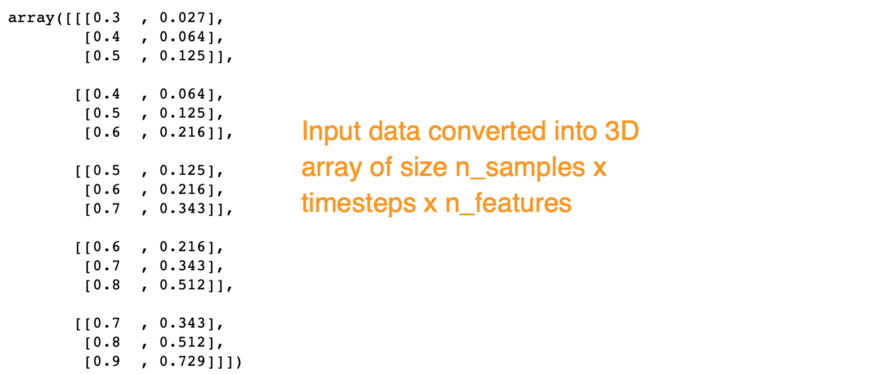

Figure 1.2. Data transformed to a 3D array for an LSTM network.


# Understanding an LSTM Autoencoder Structure
In this section, we will build an LSTM Autoencoder network, and visualize its architecture and data flow. We will also look at a regular LSTM Network to compare and contrast its differences with an Autoencoder.
Defining an LSTM Autoencoder.

In [10]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 128)            67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 128)            98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 2)              258       
Total params: 248,578
Trainable params: 248,578
Non-trainable params: 0
__________________________________________________

In [15]:
X

array([[[0.3  , 0.027],
        [0.4  , 0.064],
        [0.5  , 0.125]],

       [[0.4  , 0.064],
        [0.5  , 0.125],
        [0.6  , 0.216]],

       [[0.5  , 0.125],
        [0.6  , 0.216],
        [0.7  , 0.343]],

       [[0.6  , 0.216],
        [0.7  , 0.343],
        [0.8  , 0.512]],

       [[0.7  , 0.343],
        [0.8  , 0.512],
        [0.9  , 0.729]]])

In [11]:
# fit model
model.fit(X, X, epochs=300, batch_size=5, verbose=0)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

---Predicted---
[[[0.328 0.048]
  [0.428 0.068]
  [0.496 0.123]]

 [[0.388 0.075]
  [0.502 0.121]
  [0.591 0.215]]

 [[0.474 0.121]
  [0.598 0.209]
  [0.699 0.35 ]]

 [[0.58  0.198]
  [0.697 0.331]
  [0.808 0.515]]

 [[0.714 0.354]
  [0.8   0.518]
  [0.897 0.725]]]
---Actual---
[[[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


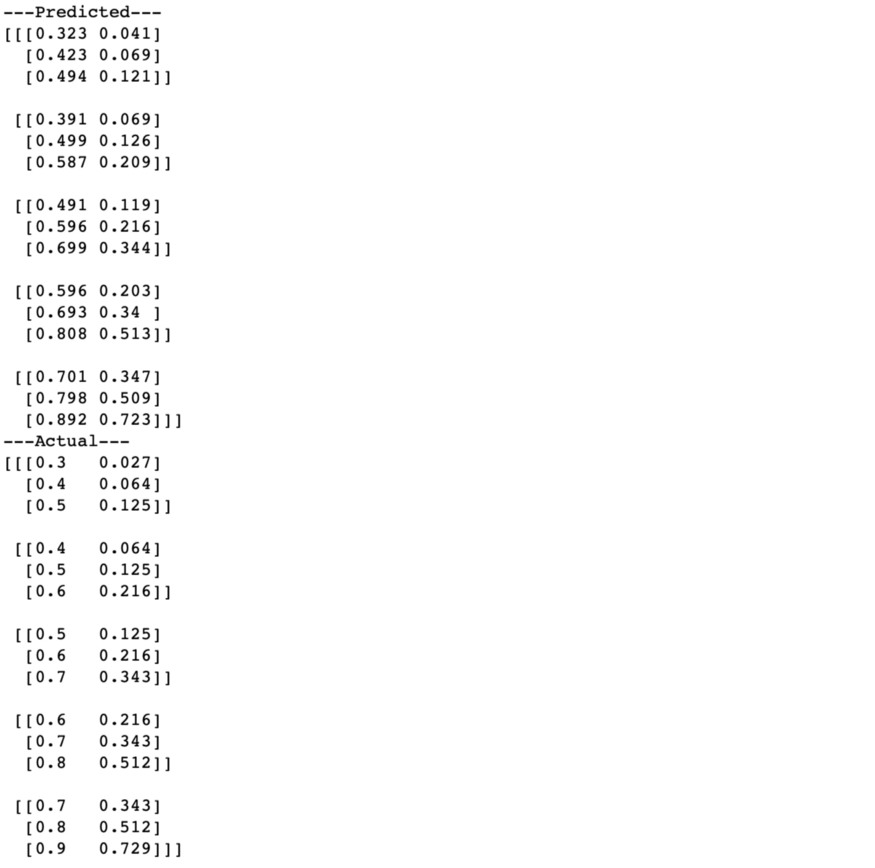
Figure 2.2. Input Reconstruction of LSTM Autoencoder.

The model.summary() provides a summary of the model architecture. For a better understanding, let’s visualize it in Figure 2.3 below.

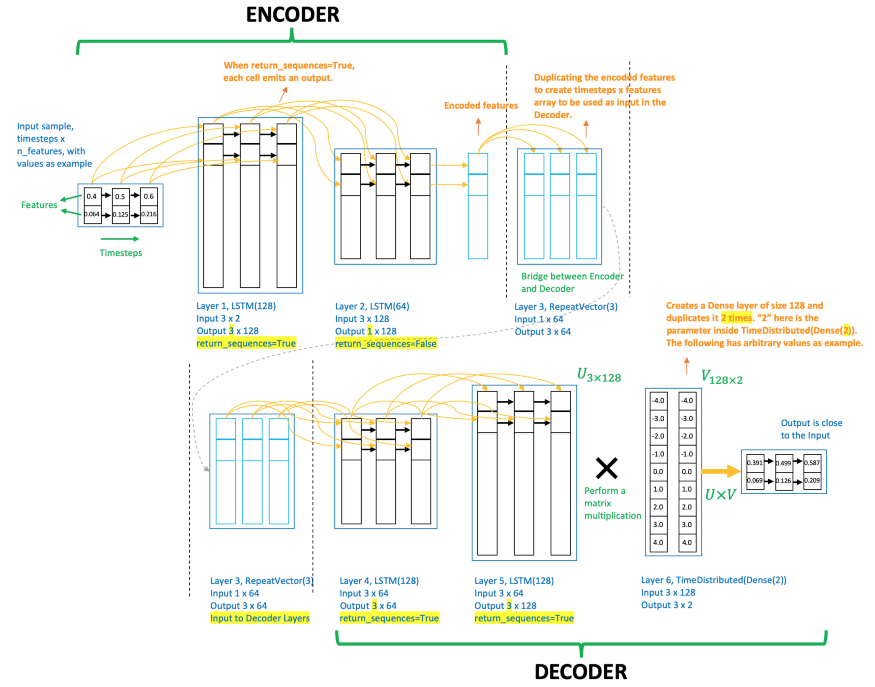
Figure 2.3. LSTM Autoencoder Flow Diagram.

The diagram illustrates the flow of data through the layers of an LSTM Autoencoder network for one sample of data. A sample of data is one instance from a dataset. In our example, one sample is a sub-array of size 3x2 in Figure 1.2.

From this diagram, we learn

The LSTM network takes a 2D array as input.

One layer of LSTM has as many cells as the timesteps.

Setting the return_sequences=True makes each cell per timestep emit a signal.

This becomes clearer in Figure 2.4 which shows the difference between return_sequences as True (Fig. 2.4a) vs False (Fig. 2.4b).

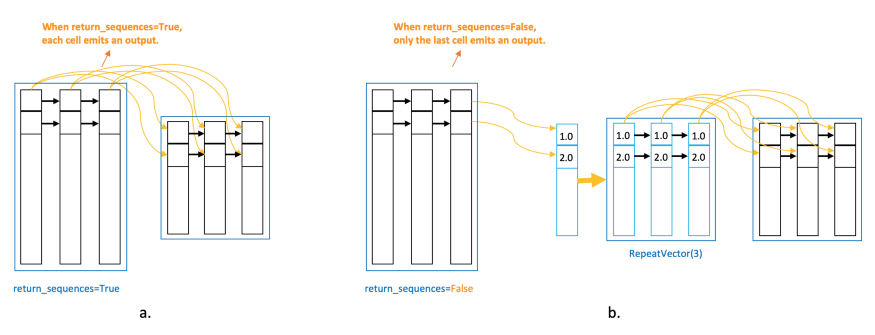

Figure 2.4. Difference between return_sequences as True and False.

In Fig. 2.4a, signal from a timestep cell in one layer is received by the cell of the same timestep in the subsequent layer.

In the encoder and decoder modules in an LSTM autoencoder, it is important to have direct connections between respective timestep cells in consecutive LSTM layers as in Fig 2.4a.

In Fig. 2.4b, only the last timestep cell emits signals. The output is, therefore, a vector.

As shown in Fig. 2.4b, if the subsequent layer is LSTM, we duplicate this vector using RepeatVector(timesteps) to get a 2D array for the next layer.

No transformation is required if the subsequent layer is Dense (because a Dense layer expects a vector as input).

Coming back to the LSTM Autoencoder in Fig 2.3.

The input data has 3 timesteps and 2 features.

Layer 1, LSTM(128), reads the input data and outputs 128 features with 3 timesteps for each because return_sequences=True.

Layer 2, LSTM(64), takes the 3x128 input from Layer 1 and reduces the feature size to 64. Since return_sequences=False, it outputs a feature vector of size 1x64.

The output of this layer is the encoded feature vector of the input data.

This encoded feature vector can be extracted and used as a data compression, or features for any other supervised or unsupervised learning (in the next post we will see how to extract this).

Layer 3, RepeatVector(3), replicates the feature vector 3 times.

The RepeatVector layer acts as a bridge between the encoder and decoder modules.

It prepares the 2D array input for the first LSTM layer in Decoder.

The Decoder layer is designed to unfold the encoding.

Therefore, the Decoder layers are stacked in the reverse order of the Encoder.

Layer 4, LSTM (64), and Layer 5, LSTM (128), are the mirror images of Layer 2 and Layer 1, respectively.

Layer 6, TimeDistributed(Dense(2)), is added in the end to get the output, where “2” is the number of features in the input data.

The TimeDistributed layer creates a vector of length equal to the number of features outputted from the previous layer. In this network, Layer 5 outputs 128 features. Therefore, the TimeDistributed layer creates a 128 long vector and duplicates it 2 (= n_features) times.

The output of Layer 5 is a 3x128 array that we denote as U and that of TimeDistributed in Layer 6 is 128x2 array denoted as V. A matrix multiplication between U and V yields a 3x2 output.

The objective of fitting the network is to make this output close to the input. Note that this network itself ensured that the input and output dimensions match.

# Comparing LSTM Autoencoder with a regular LSTM Network

The above understanding gets clearer when we compare it with a regular LSTM network built for reconstructing the inputs.

In [12]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 128)            67072     
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 64)             49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 2)              258       
Total params: 248,578
Trainable params: 248,578
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit model
model.fit(X, X, epochs=300, batch_size=5, verbose=0)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

---Predicted---
[[[0.334 0.066]
  [0.401 0.051]
  [0.499 0.119]]

 [[0.391 0.094]
  [0.507 0.123]
  [0.603 0.222]]

 [[0.472 0.142]
  [0.602 0.214]
  [0.697 0.346]]

 [[0.588 0.217]
  [0.703 0.342]
  [0.8   0.519]]

 [[0.725 0.314]
  [0.797 0.518]
  [0.905 0.73 ]]]
---Actual---
[[[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


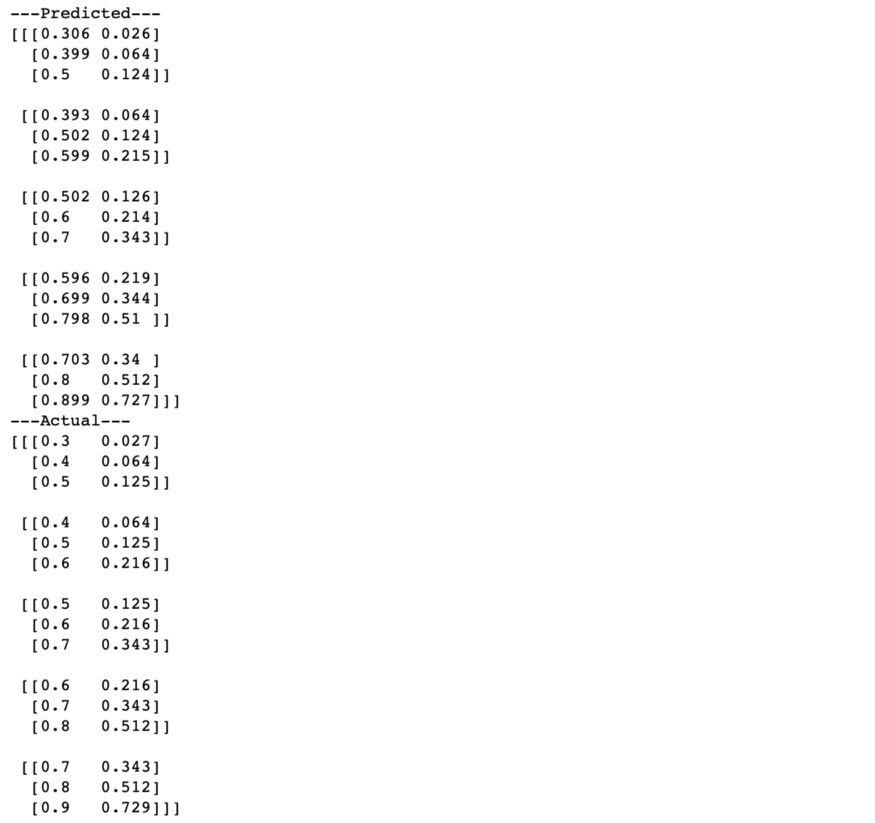
Figure 3.2. Input Reconstruction of regular LSTM network.

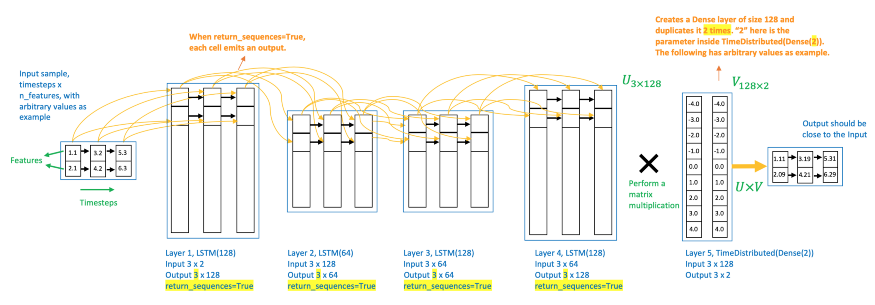

Figure 3.3. Regular LSTM Network flow diagram.

# Differences between Regular LSTM network and LSTM Autoencoder

We are using return_sequences=True in all the LSTM layers.

That means, each layer is outputting a 2D array containing each timesteps.

Thus, there is no one-dimensional encoded feature vector as output of any intermediate layer. Therefore, encoding a sample into a feature vector is not happening.

Absence of this encoding vector differentiates the regular LSTM network for reconstruction from an LSTM Autoencoder.

However, note that the number of parameters is the same in both, the Autoencoder (Fig. 2.1) and the Regular network (Fig. 3.1).

This is because, the extra RepeatVector layer in the Autoencoder does not have any additional parameter.

Most importantly, the reconstruction accuracies of both Networks are similar.

# Food for thought

The rare-event classification using anomaly detection approach discussed in LSTM Autoencoder for rare-event classification [1] is training an LSTM Autoencoder to detect the rare events. The objective of the Autoencoder network in [1] is to reconstruct the input and classify the poorly reconstructed samples as a rare event.

Since, we can also build a regular LSTM network to reconstruct a time-series data as shown in Figure 3.3, will that improve the results?

The hypothesis behind this is,

due to the absence of an encoding layer the accuracy of reconstruction can be better in some cases (because the dimension time-dimension is not reduced). Unless the encoded vector is required for any other analysis, trying a regular LSTM network is worth a try for a rare-event classification.


Github Repository
The complete code can be found here.

# Conclusion
In this article, we

worked with a toy example to understand an LSTM network layer-by-layer.

understood the input and output flow from and between each layer.

understood the meaning of return_sequences , RepeatVector() , and TimeDistributed().

compared and contrasted an LSTM Autoencoder with a regular LSTM network.


# References

LSTM Autoencoder for Extreme Rare Event Classification in Keras

A Gentle Introduction to LSTM Autoencoders

Understanding LSTM and its diagrams

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [24]:
# univariate data preparation
from numpy import array

# univariate data preparation
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [25]:
n_features = 1

In [26]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [28]:
X.shape[0]

6

In [29]:
X.shape[1]

3

In [30]:
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [31]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [32]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

In [33]:
print(yhat)

[[103.74878]]
